In [1]:
# Import libraries.
using Turing, StatsPlots, Random, Memoization

## The model of agent as universal Probalistic Model
### gets some parmeters:
<ul>
    <li> opponent agent - representation of our belief on the opponent model (Turing.jl model)
    <li> my history - list of all moves this player done (At this point unused)
    <li> opponent history - list of all moves the opponent done, used to estimate a prior on the moves
    <li> depth - the depth we want the agent will dive modeling the mind of opponent agent
</ul>        

In [2]:
N = 10000
INFALG = IS()
PRIOR_POLICY = [1,1,1]
PDIRAC = 0.95

0.95

In [18]:
function winning(opp_move)
    best_moves = Dict(1 => 2, 2 => 3, 3 => 1)
    move = best_moves[opp_move]
    return move
end

winning (generic function with 1 method)

In [19]:
@model function agent(opponent_chn, opponent_history, opp_prior_policy = [1,1,1], depth = 1)
    beta_opp ~ Dirichlet(opp_prior_policy) #prior
    if depth == 0
        for opp_move in opponent_history
            opp_move ~ Categorical(beta_opp) # observe
        end
    end
    next_opp_move ~ Categorical(beta_opp) # sample
    opp_move_sample = next_opp_move
    if depth > 0
        weights = exp.(opponent_chn[:lp][:, 1])
        idx ~ Categorical(weights/sum(weights))
        opp_move_sample = opponent_chn[:next_opp_move][idx, 1]
    end
     # init alternative way to Dirac distribution
    complete_p_dirac = (1 - PDIRAC) / 2
    phi = fill(complete_p_dirac, 3)
    phi[winning(next_opp_move)] = PDIRAC
    
    my_move = winning(opp_move_sample)
    my_move ~ Categorical(phi) # Dirac(next_opp_move) / observe(next_opponent_move, infered_opponent_move)
end

agent (generic function with 3 methods)

In [23]:
# Plot the results
function plotChn(chn)
    histogram(chn[:my_move], weights=exp.(chn[:lp]), normalize=:probability)
end

plotChn (generic function with 1 method)

In [30]:
function run_two_agents_theory_of_mind(first_model, second_model, first_player_history, second_player_history ,depth)
    second_chn_i = []
    first_chn_i = []
    for i in 0:depth
        first_chn_i = sample(first_model(second_chn_i, second_player_history, PRIOR_POLICY, i),  INFALG, N)
        second_chn_i = sample(second_model(first_chn_i, first_player_history, PRIOR_POLICY, i), INFALG, N)
    end
    display(first_chn_i)
    plotChn(first_chn_i)
end

run_two_agents_theory_of_mind (generic function with 1 method)

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:01
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:01
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:06
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:04
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:04
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:04


Chains MCMC chain (10000×7×1 Array{Float64,3}):

Log evidence      = 0.0
Iterations        = 1:10000
Thinning interval = 1
Chains            = 1
Samples per chain = 10000
parameters        = beta_opp[1], beta_opp[2], beta_opp[3], idx, my_move, next_opp_move
internals         = lp

Summary Statistics
     parameters        mean         std   naive_se      mcse          ess      ⋯
         Symbol     Float64     Float64    Float64   Float64      Float64   Fl ⋯

    beta_opp[1]      0.3341      0.2368     0.0024    0.0025    9958.1144    1 ⋯
    beta_opp[2]      0.3315      0.2352     0.0024    0.0022    9935.2824    1 ⋯
    beta_opp[3]      0.3345      0.2380     0.0024    0.0025    9867.9531    0 ⋯
            idx   4996.0173   2865.8066    28.6581   23.0121   10086.0680    0 ⋯
        my_move      1.9941      0.8190     0.0082    0.0084    9972.0752    0 ⋯
  next_opp_move      2.0077      0.8182     0.0082    0.0077    9939.6809    0 ⋯
                                                  

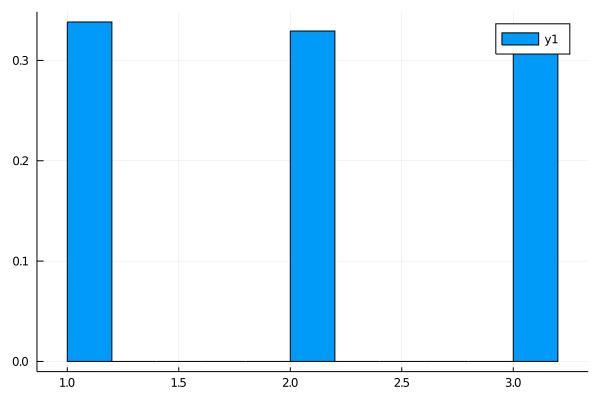

In [31]:
run_two_agents_theory_of_mind(agent, agent, [1,3,1,3,1,1,3,1,3,1] , [1,3,1,3,1,1,3,1,3,1], 2)